In [4]:
from scprint import scPrint
from scdataloader import Preprocessor

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc

from anndata.utils import make_index_unique
from bengrn import compute_genie3, get_GT_db
from grnndata import utils as grnutils
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2 

import sys
import os

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch

os.environ["KMP_WARNINGS"] = "off"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


In [6]:
genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/vbd8bavn/checkpoints/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
#../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
NUM_GENES = 5000
MAXCELLS = 1024

In [7]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.



# han / full


In [25]:
metrics = {}

In [24]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 103/103 [01:24<00:00,  1.22it/s]


precision:  0.02740789449650209 
recall:  1.0 
random precision: 0.02741340251388483


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2349.78it/s]


Area Under Precision-Recall Curve (AUPRC):  0.031558898757870296
EPR: 1.2175033402187991


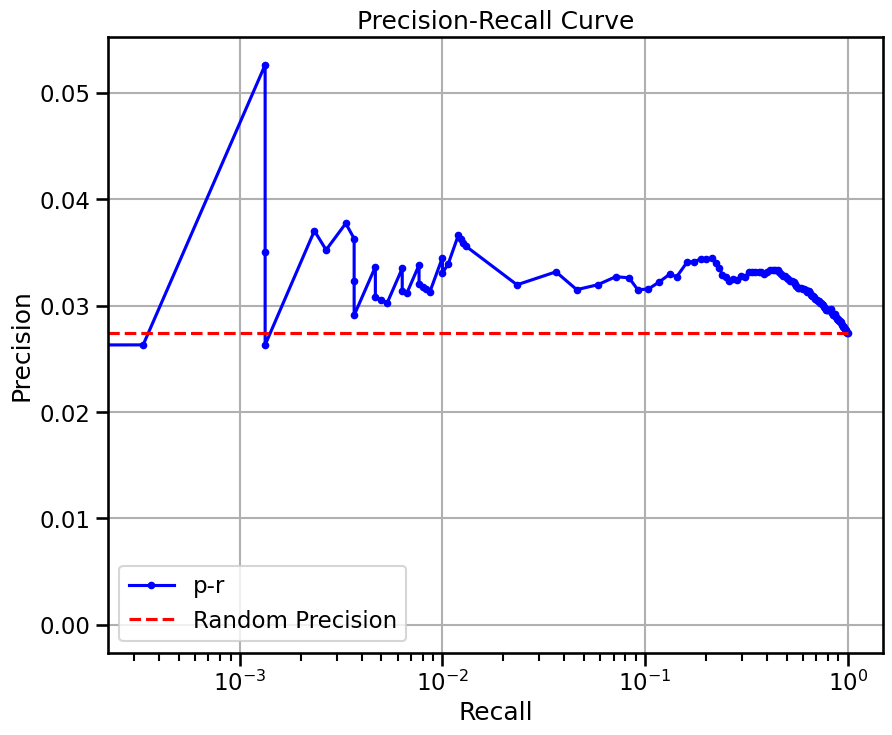

In [26]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")
grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)
grn.var.index.name=""
grn.var['symbol'] = grn.var.index
metrics['scGPT_han'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


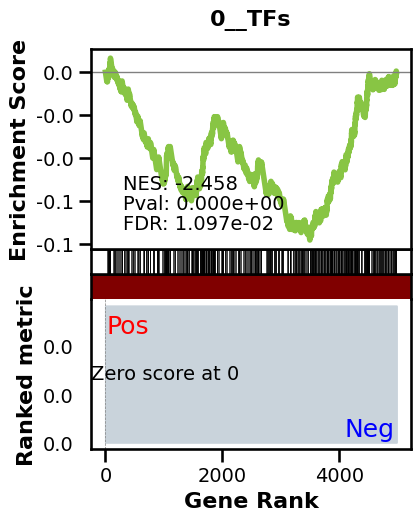

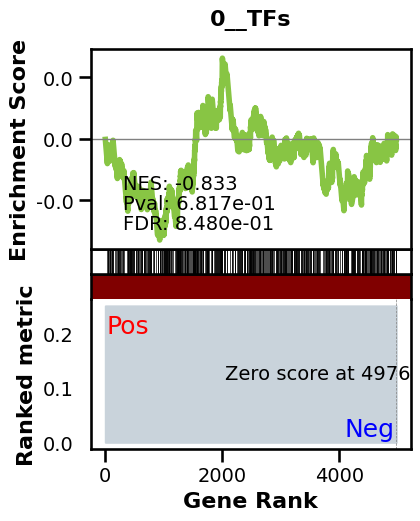

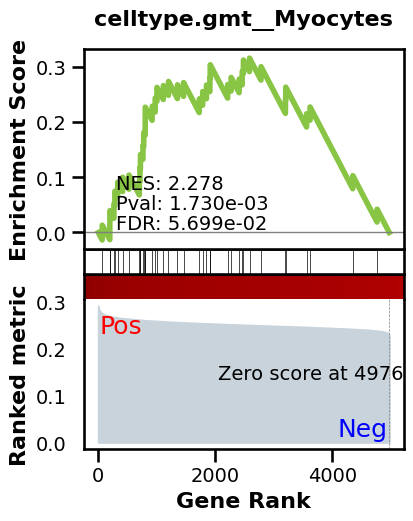

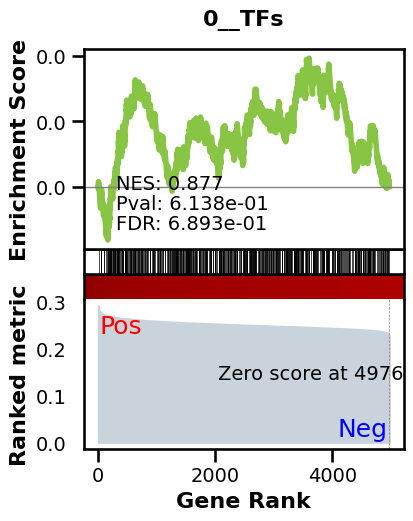

_________________________________________
TF specific enrichment
found some significant results for  16.9811320754717 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3749 genes
intersection pct: 0.7532650190878039
precision:  0.0015233012078761147 
recall:  1.0 
random precision: 0.0015237076382944382


 98%|█████████▊| 125/128 [00:02<00:00, 44.50it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 44.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0016869861309902964
EPR: 0.8886533782936475


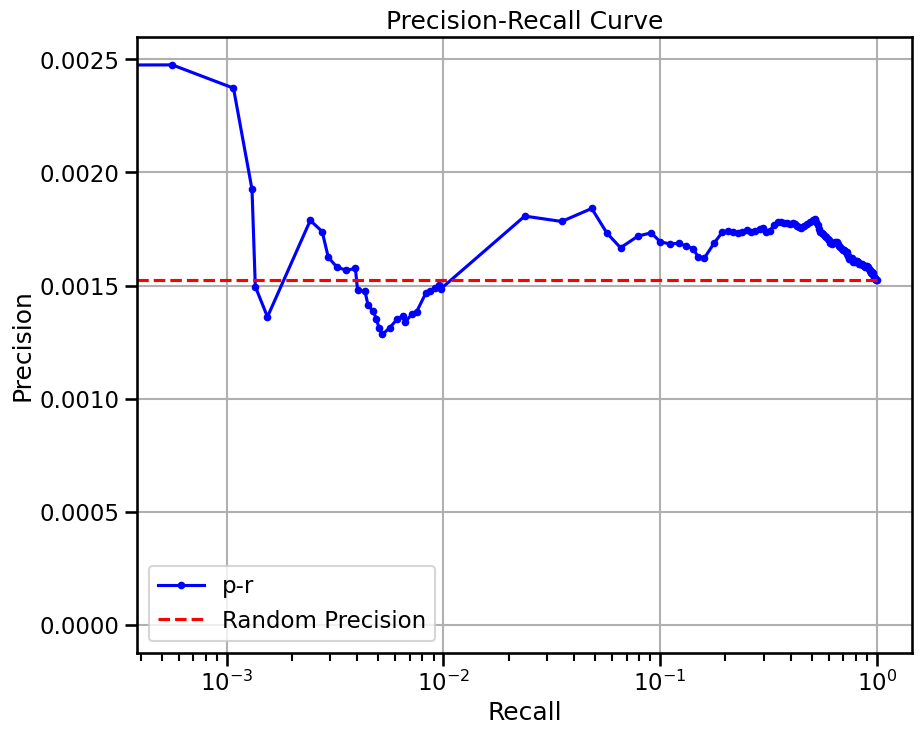

In [27]:
metrics['scGPT_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.2536840196611731 
recall:  1.0 
random precision: 0.2537350011763783


 89%|████████▉ | 114/128 [00:00<00:00, 576.44it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 562.69it/s]


Area Under Precision-Recall Curve (AUPRC):  0.24860467992523433
EPR: 0.9497363111215568


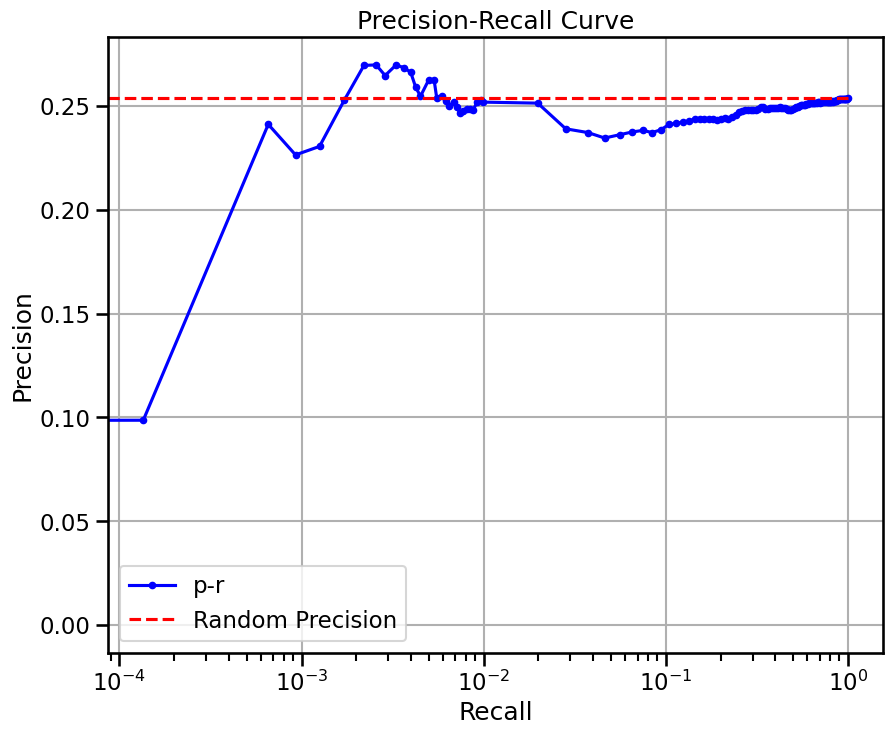

In [28]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scGPT_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.07659519504004134 
recall:  1.0 
random precision: 0.07661058796508957


 67%|██████▋   | 86/128 [00:00<00:00, 426.37it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 428.16it/s]


Area Under Precision-Recall Curve (AUPRC):  0.09574573034240853
EPR: 1.49396093316715


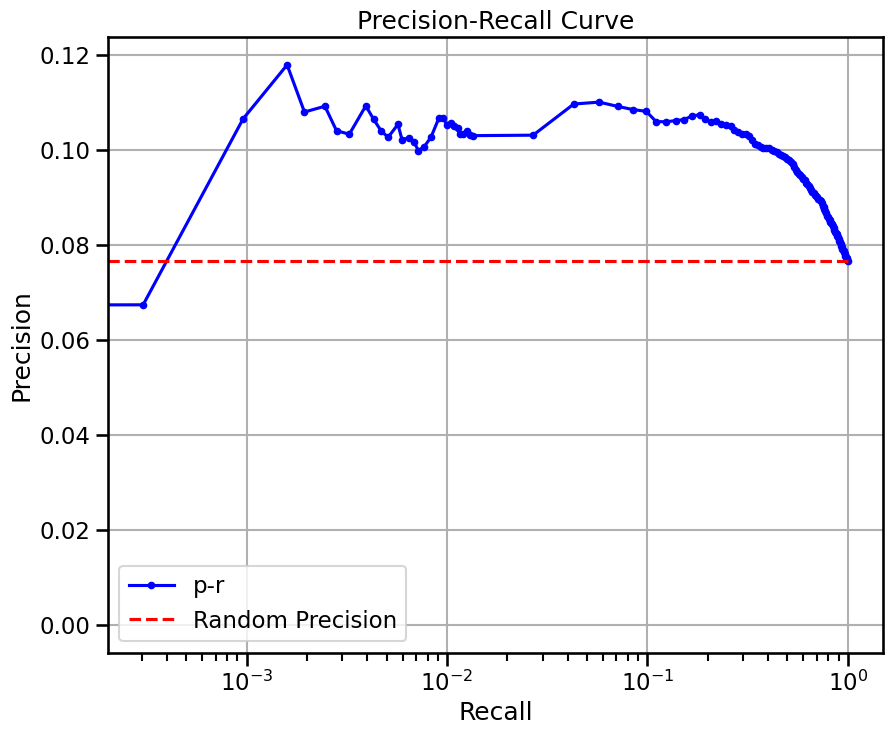

In [29]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scGPT_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## trial with my own ESC

In [30]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining
filtered out 0 cells, 115 renamining
Removed 0 genes.
startin QC
Seeing 104 outliers (90.43% of total dataset):
done


(GRnnData object with n_obs × n_vars = 115 × 28466
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11563 elements,
 35)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


precision:  0.03218094660043849 
recall:  1.0 
random precision: 0.032188522152839724


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2573.88it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03247126893678103
EPR: 1.0175634254601895


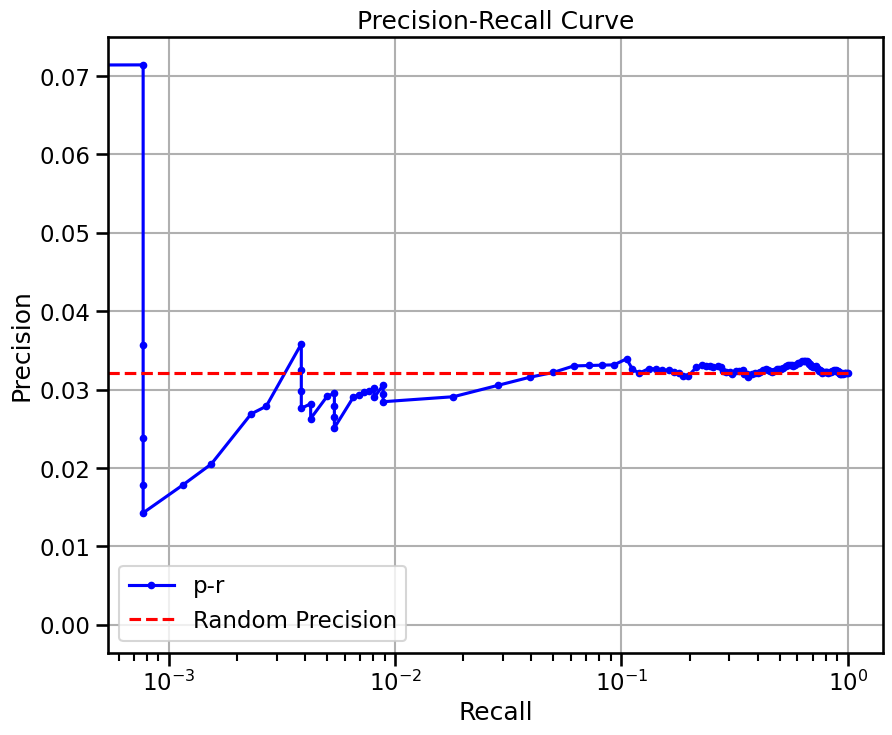

In [31]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")
grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)
grn.var.index.name=""
grn.var['symbol'] = grn.var.index
metrics['scGPT_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


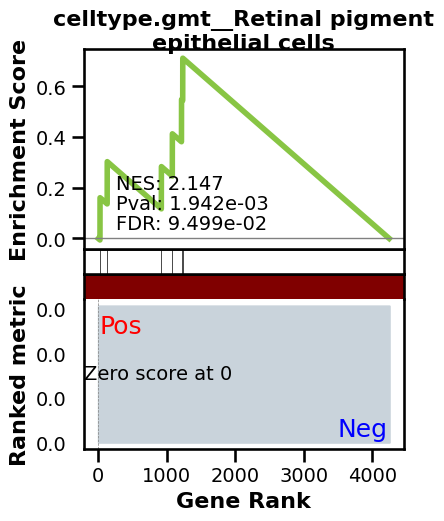

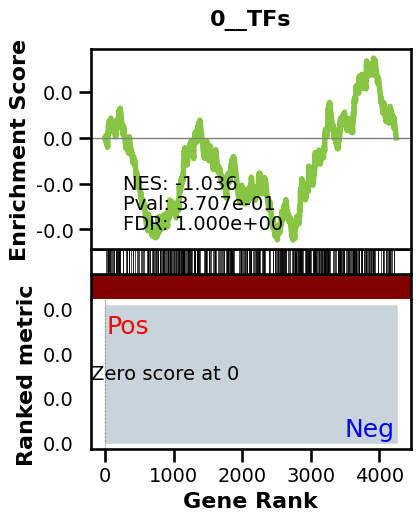

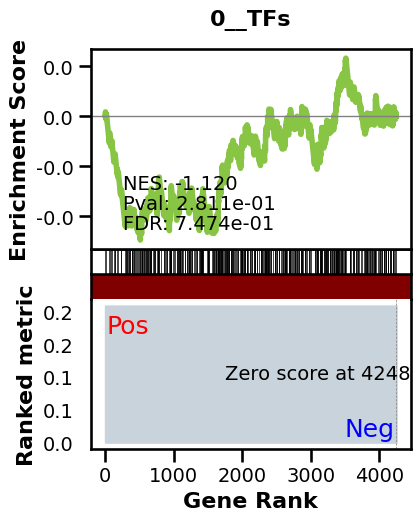

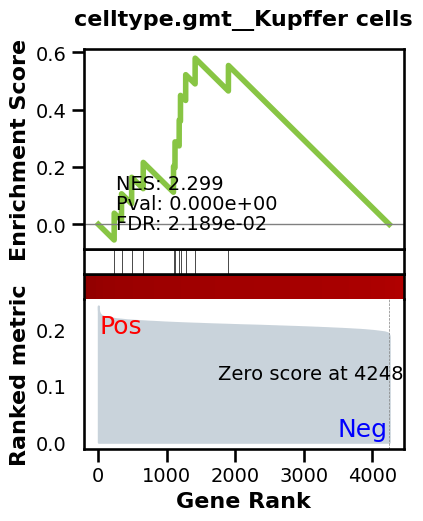

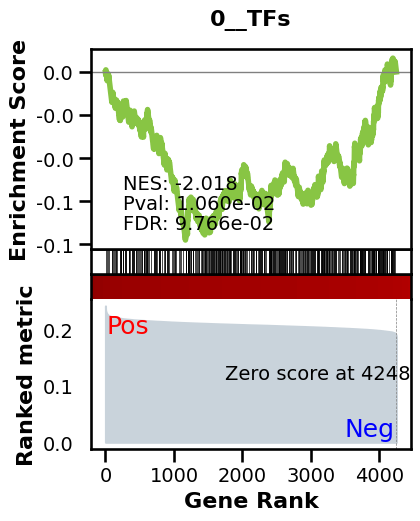

_________________________________________
TF specific enrichment
found some significant results for  20.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2821 genes
intersection pct: 0.6639209225700164
precision:  0.0015265063349133286 
recall:  1.0 
random precision: 0.0015270476492164893


 98%|█████████▊| 126/128 [00:01<00:00, 82.49it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 81.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.001581454288164285
EPR: 0.16130586889141957


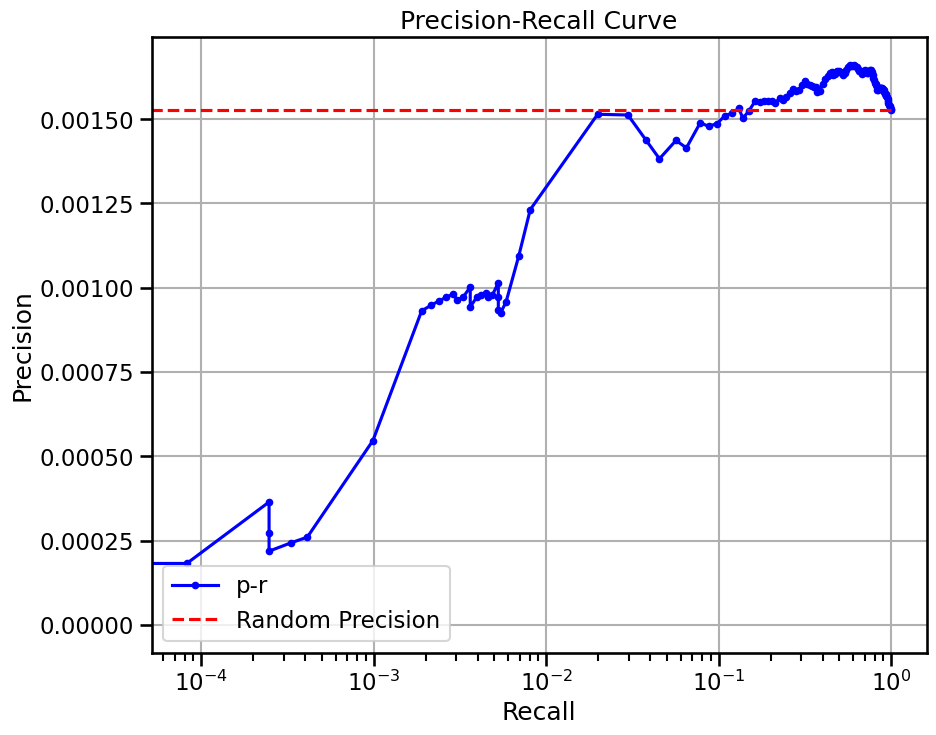

In [34]:
metrics['scGPT_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [35]:
metrics

{'scGPT_han': {'precision': 0.02740789449650209,
  'recall': 1.0,
  'rand_precision': 0.02741340251388483,
  'auprc': 0.031558898757870296,
  'epr': 1.2175033402187991},
 'scGPT_han_base': {'TF_enr': True,
  'enriched_terms_Regulators': ['celltype.gmt__Myocytes',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Oligodendrocyte precursor cells',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Enterocytes',
   'celltype.gmt__Satellite cells',
   'celltype.gmt__Adipose progenitor cells',
   'celltype.gmt__Lymphatic Endothelial cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Enteric neurons',
   'celltype.gmt__Enterochromaffin cells',
   'celltype.gmt__Cholinergic GABAergic amacrine cells',
   'celltype.gmt__Tachykinin GABAergic amacrine cells',
   'celltype.gmt__GABAergic amacrine cells',
   'celltype.gmt__Glycinergic amacrine cells',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Peri-islet Schwann cells',
   'cellty

In [36]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append([k.split('_')[-2]+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append([k.split('_')[-2]+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,han,1.217503,0.031559,0.027413,False
1,han_chip,0.949736,0.248605,0.253735,False
2,han_ko,1.493961,0.095746,0.076611,False
3,mine,1.017563,0.032471,0.032189,False


: 

In [ ]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,han,1.781345,0.001695,0.001522,5.660377,False,True
1,han,9.071017,0.004797,0.001522,7.547170,True,False
2,mine,9.414169,0.006973,0.001508,2.500000,True,True
3,mine,0.824358,0.001692,0.001508,5.000000,False,False
